# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from model import HART
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings("ignore")

2025-05-07 15:11:00.798084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 15:11:00.807204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 15:11:00.810030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 15:11:00.817401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 15:11:01.291391: W tensorflow/compiler/tf2

# Checking GPU Availability

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

tf.keras.backend.set_image_data_format('channels_last')

Num GPUs Available:  2
2 Physical GPUs, 2 Logical GPUs


I0000 00:00:1746645062.123409  618212 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746645062.125085  618212 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746645062.146256  618212 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746645062.147760  618212 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

# Loading the Dataset

In [3]:
file_path = 'SMOTE_Scaled_Combined_Active_Gyro_Accel_Cleaned_V2.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"Loaded {file_path} successfully")
else:
    print(f"File not found: {file_path}. Please ensure the file is available or check the path.")

Loaded SMOTE_Scaled_Combined_Active_Gyro_Accel_Cleaned_V2.csv successfully


# Selecting Required Columns

In [4]:
required_cols = ['Accel X (g)', 'Accel Y (g)', 'Accel Z (g)', 
                'Gyro X (°/s)', 'Gyro Y (°/s)', 'Gyro Z (°/s)', 
                'Subject_ID', 'Activity_Label']

if all(col in df.columns for col in required_cols):
    df = df[required_cols]
    print("Selected only the required columns")
else:
    print("Column names don't match exactly, using available columns...")
    accel_cols = [col for col in df.columns if 'accel' in col.lower() or 'acc' in col.lower()][:3]
    gyro_cols = [col for col in df.columns if 'gyro' in col.lower()][:3]
    subject_col = [col for col in df.columns if 'subject' in col.lower() or 'id' in col.lower()][0]
    activity_col = [col for col in df.columns if 'activity' in col.lower() or 'label' in col.lower()][0]
    
    df = df[accel_cols + gyro_cols + [subject_col, activity_col]]
    df.columns = required_cols

Selected only the required columns


# Displaying Basic Dataset Information

In [5]:
print("Data summary:")
print(df.head())
print("\nActivity distribution:")
print(df['Activity_Label'].value_counts())
print("\nSubject distribution:")
print(df['Subject_ID'].value_counts())

Data summary:
   Accel X (g)  Accel Y (g)  Accel Z (g)  Gyro X (°/s)  Gyro Y (°/s)  \
0     -5.98311     1.247379     8.365341      0.321315     -0.024435   
1     -5.98311     1.247379     8.365341      0.321315     -0.024435   
2     -5.98311     1.247379     8.365341      0.321315     -0.024435   
3     -5.98311     1.247379     8.365341      0.321315     -0.024435   
4     -5.98311     1.247379     8.365341      0.321315     -0.024435   

   Gyro Z (°/s)  Subject_ID Activity_Label  
0     -0.131947           1   Chair Squats  
1     -0.131947           1   Chair Squats  
2     -0.131947           1   Chair Squats  
3     -0.131947           1   Chair Squats  
4     -0.131947           1   Chair Squats  

Activity distribution:
Activity_Label
Chair Squats                   36556
Light Stationary Cycling       36556
Marching in Place              36556
Seated Boxing Hooks            36556
Seated Leg Extensions          36556
Seated Medicine Ball Twists    36556
Seated Side Bends     

# Normalizing Data by Subject

In [6]:
subjects = df['Subject_ID'].unique()
normalized_dfs = []

for subject in subjects:
    subject_df = df[df['Subject_ID'] == subject].copy()
    sensor_cols = ['Accel X (g)', 'Accel Y (g)', 'Accel Z (g)', 
                   'Gyro X (°/s)', 'Gyro Y (°/s)', 'Gyro Z (°/s)']
    
    original_means = subject_df[sensor_cols].mean()
    original_stds = subject_df[sensor_cols].std()
    
    scaler = RobustScaler()
    subject_df[sensor_cols] = scaler.fit_transform(subject_df[sensor_cols])
    
    mask = (((subject_df[sensor_cols] >= (original_means - 2 * original_stds)) & 
             (subject_df[sensor_cols] <= (original_means + 2 * original_stds)))
            .all(axis=1))
    
    subject_df_filtered = subject_df[mask].dropna()
    
    print(f"Subject {subject}: Original rows: {len(subject_df)}, After filtering: {len(subject_df_filtered)}, " 
          f"Removed: {len(subject_df) - len(subject_df_filtered)} ({(len(subject_df) - len(subject_df_filtered))/len(subject_df)*100:.2f}%)")
    
    normalized_dfs.append(subject_df_filtered)

df = pd.concat(normalized_dfs)
print(f"\nTotal rows after filtering: {len(df)}")

Subject 1: Original rows: 62223, After filtering: 23096, Removed: 39127 (62.88%)
Subject 2: Original rows: 62456, After filtering: 41248, Removed: 21208 (33.96%)
Subject 3: Original rows: 60855, After filtering: 22216, Removed: 38639 (63.49%)
Subject 4: Original rows: 61161, After filtering: 35893, Removed: 25268 (41.31%)
Subject 5: Original rows: 51243, After filtering: 37683, Removed: 13560 (26.46%)
Subject 6: Original rows: 67622, After filtering: 47906, Removed: 19716 (29.16%)

Total rows after filtering: 208042


# Encoding Activity Labels

In [7]:
print("\nEncoding activity labels...")
label_encoder = LabelEncoder()
df['Activity_Encoded'] = label_encoder.fit_transform(df['Activity_Label'])

activity_names = label_encoder.classes_
activity_mapping = dict(zip(range(len(activity_names)), activity_names))

print("\nActivity mapping:")
for i, activity in enumerate(activity_names):
    print(f"{i}: {activity}")


Encoding activity labels...

Activity mapping:
0: Chair Squats
1: Light Stationary Cycling
2: Marching in Place
3: Seated Boxing Hooks
4: Seated Leg Extensions
5: Seated Medicine Ball Twists
6: Seated Side Bends
7: Side-Stepping
8: Standing Heel-to-Toe Walk
9: Wall Push-ups


# Windowing Functions

In [8]:
def create_overlapping_windows(data, window_size=128, step_size=64, features=6):
    segments = []
    for start in range(0, len(data) - window_size + 1, step_size):
        segment = data[start:start + window_size, :features]
        segments.append(segment)
    return np.array(segments)

def assign_labels_to_windows(labels, window_size=128, step_size=64):
    window_labels = []
    for start in range(0, len(labels) - window_size + 1, step_size):
        window_label = np.bincount(labels[start:start + window_size]).argmax()
        window_labels.append(window_label)
    return np.array(window_labels)

# Train, Validation, and Test Split

In [9]:
window_size = 128
step_size = 64
num_features = 6

subject_5_valid_activities = set([
    'Marching in Place',
    'Wall Push-ups',
    'Seated Boxing Hooks',
    'Standing Heel-to-Toe Walk'
])
subject_5_valid_activities_encoded = set([list(activity_mapping.keys())[list(activity_mapping.values()).index(activity)] 
                                         for activity in subject_5_valid_activities])

X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []

print("Processing data by subject and activity:")

for subject_id in df['Subject_ID'].unique():
    subject_df = df[df['Subject_ID'] == subject_id]
    
    for activity_label in subject_df['Activity_Encoded'].unique():
        if subject_id == 5 and activity_label not in subject_5_valid_activities_encoded:
            continue
        
        activity_df = subject_df[subject_df['Activity_Encoded'] == activity_label]
        
        features = activity_df[sensor_cols].values
        labels = activity_df['Activity_Encoded'].values
        
        if len(features) >= window_size:
            windows = create_overlapping_windows(features, window_size, step_size, num_features)
            window_labels = assign_labels_to_windows(labels, window_size, step_size)
            
            if len(windows) > 0:
                train_idx = max(1, int(len(windows) * 0.7))
                val_idx = max(train_idx + 1, int(len(windows) * 0.85))
                
                print(f"Subject {subject_id}, Activity {activity_mapping.get(activity_label, 'Unknown')}: " 
                      f"Data length: {len(features)}, Windows: {len(windows)}, "
                      f"Train: {train_idx}, Val: {val_idx-train_idx}, Test: {len(windows)-val_idx}")
                
                if train_idx > 0:
                    X_train_list.append(windows[:train_idx])
                    y_train_list.append(window_labels[:train_idx])
                
                if val_idx > train_idx:
                    X_val_list.append(windows[train_idx:val_idx])
                    y_val_list.append(window_labels[train_idx:val_idx])
                
                if len(windows) > val_idx:
                    X_test_list.append(windows[val_idx:])
                    y_test_list.append(window_labels[val_idx:])
            else:
                print(f"Warning: Subject {subject_id}, Activity {activity_mapping.get(activity_label, 'Unknown')}: No windows created (data length: {len(features)})")
        else:
            print(f"Warning: Subject {subject_id}, Activity {activity_mapping.get(activity_label, 'Unknown')}: Not enough data for windowing (data length: {len(features)})")

if X_train_list and all(isinstance(arr, np.ndarray) and arr.ndim == 3 for arr in X_train_list):
    X_train = np.concatenate(X_train_list)
    y_train = np.concatenate(y_train_list)
    print(f"Train shape: {X_train.shape}, Labels: {y_train.shape}")
else:
    print("Error: Training data is empty or contains arrays with incorrect dimensions")
    for i, arr in enumerate(X_train_list):
        if not isinstance(arr, np.ndarray):
            print(f"  Item {i} is not a numpy array: {type(arr)}")
        elif arr.ndim != 3:
            print(f"  Item {i} has wrong dimensions: {arr.shape}")

if X_val_list and all(isinstance(arr, np.ndarray) and arr.ndim == 3 for arr in X_val_list):
    X_val = np.concatenate(X_val_list)
    y_val = np.concatenate(y_val_list)
    print(f"Validation shape: {X_val.shape}, Labels: {y_val.shape}")
else:
    print("Error: Validation data is empty or contains arrays with incorrect dimensions")

if X_test_list and all(isinstance(arr, np.ndarray) and arr.ndim == 3 for arr in X_test_list):
    X_test = np.concatenate(X_test_list)
    y_test = np.concatenate(y_test_list)
    print(f"Test shape: {X_test.shape}, Labels: {y_test.shape}")
else:  
    print("Error: Test data is empty or contains arrays with incorrect dimensions")

Processing data by subject and activity:
Subject 1, Activity Chair Squats: Data length: 2600, Windows: 39, Train: 27, Val: 6, Test: 6
Subject 1, Activity Light Stationary Cycling: Data length: 2371, Windows: 36, Train: 25, Val: 5, Test: 6
Subject 1, Activity Marching in Place: Data length: 3646, Windows: 55, Train: 38, Val: 8, Test: 9
Subject 1, Activity Seated Leg Extensions: Data length: 5604, Windows: 86, Train: 60, Val: 13, Test: 13
Subject 1, Activity Seated Medicine Ball Twists: Data length: 1770, Windows: 26, Train: 18, Val: 4, Test: 4
Subject 1, Activity Seated Side Bends: Data length: 3569, Windows: 54, Train: 37, Val: 8, Test: 9
Subject 1, Activity Standing Heel-to-Toe Walk: Data length: 785, Windows: 11, Train: 7, Val: 2, Test: 2
Subject 1, Activity Wall Push-ups: Data length: 2745, Windows: 41, Train: 28, Val: 6, Test: 7
Subject 2, Activity Chair Squats: Data length: 6489, Windows: 100, Train: 70, Val: 15, Test: 15
Subject 2, Activity Light Stationary Cycling: Data length: 

# Class Distribution in Training Set

In [10]:
print("\nClass distribution in training set:")
for activity_id, count in zip(*np.unique(y_train, return_counts=True)):
    print(f"{activity_mapping[activity_id]}: {count} samples")


Class distribution in training set:
Chair Squats: 214 samples
Light Stationary Cycling: 310 samples
Marching in Place: 295 samples
Seated Boxing Hooks: 95 samples
Seated Leg Extensions: 288 samples
Seated Medicine Ball Twists: 118 samples
Seated Side Bends: 182 samples
Side-Stepping: 192 samples
Standing Heel-to-Toe Walk: 215 samples
Wall Push-ups: 286 samples


# Initializing the HART Model

In [11]:
input_shape = (window_size, num_features)
num_classes = len(activity_mapping)

print("\nInitializing HART model...")
model = HART(
    input_shape=input_shape,
    activityCount=num_classes,
    projection_dim=192,
    patchSize=16,
    timeStep=16,
    num_heads=3,
    filterAttentionHead=4,
    convKernels=[3, 7, 15, 31, 31, 31],
    mlp_head_units=[1024],
    dropout_rate=0.3
)

model.summary()


Initializing HART model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_patches      │ (None, 8, 192)    │      9,408 │ input_layer[0][0] │
│ (SensorPatches)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 8, 192)    │      1,536 │ sensor_patches[0… │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalizedInputs_0  │ (None, 8, 192)    │        384 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AccMHA_0            │ (None, 8, 48)     │     28,128 │ normalizedInputs… │
│ (SensorWiseMHA)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ liteFormer_0        │ (None, 8, 96)     │         12 │ normalizedInputs… │
│ (liteFormer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GyroMHA_0           │ (None, 8, 48)     │     28,128 │ normalizedInputs… │
│ (SensorWiseMHA)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 192)    │          0 │ AccMHA_0[0][0],   │
│ (Concatenate)       │                   │            │ liteFormer_0[0][… │
│                     │                   │            │ GyroMHA_0[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 192)    │          0 │ concatenate[0][0… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 8, 192)    │        384 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8, 384)    │     74,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 384)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8, 192)    │     73,920 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_path_3         │ (None, 8, 192)    │          0 │ dense_1[0][0]     │
│ (DropPath)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 8, 192)    │          0 │ drop_path_3[0][0… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalizedInputs_1  │ (None, 8, 192)    │        384 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AccMHA_1            │ (None, 8, 48)     │     28,128 │ normalizedInputs… │
│ (SensorWiseMHA)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,450,018 (5.53 MB)

 Trainable params: 1,450,018 (5.53 MB)

 Non-trainable params: 0 (0.00 B)

# Compute Class Weights

In [12]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("\nClass weights for handling imbalance:")
print(class_weights_dict)


Class weights for handling imbalance:
{0: 1.0257009345794392, 1: 0.7080645161290322, 2: 0.7440677966101695, 3: 2.3105263157894735, 4: 0.7621527777777778, 5: 1.8601694915254237, 6: 1.206043956043956, 7: 1.1432291666666667, 8: 1.0209302325581395, 9: 0.7674825174825175}


# Compile the Model

In [13]:
learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Set Up Callbacks

In [14]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'hart_best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

interval_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'hart_epoch_{epoch:03d}.keras',
    save_freq=100 * (len(X_train) // 32),
    verbose=0
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1),
    model_checkpoint,
    interval_checkpoint
]

# Train the Model

In [15]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=500,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/500


I0000 00:00:1746645076.472096  618279 service.cc:146] XLA service 0x7f544001a100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746645076.472129  618279 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1746645076.472134  618279 service.cc:154]   StreamExecutor device (1): Quadro P6000, Compute Capability 6.1
2025-05-07 15:11:16.897346: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-07 15:11:17.440598: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. functional_1/AccMHA_0_1/drop_path_1_1/random_uniform/RandomUniform
2025-05-07 15:11:18.522957: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

66/69 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2439 - loss: 2.1238

2025-05-07 15:11:44.697462: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21860', 24 bytes spill stores, 24 bytes spill loads

2025-05-07 15:11:44.709969: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21860', 32 bytes spill stores, 32 bytes spill loads

2025-05-07 15:11:44.782751: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21860', 12 bytes spill stores, 12 bytes spill loads

2025-05-07 15:11:44.958444: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21611', 96 bytes spill stores, 96 bytes spill loads

2025-05-07 15:11:45.509711: I external/local_xla/xla/str

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.2479 - loss: 2.1125
Epoch 1: val_loss improved from inf to 1.36343, saving model to hart_best_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 61s 407ms/step - accuracy: 0.2492 - loss: 2.1088 - val_accuracy: 0.5535 - val_loss: 1.3634
Epoch 2/500
65/69 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4951 - loss: 1.4663
Epoch 2: val_loss improved from 1.36343 to 1.17369, saving model to hart_best_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4972 - loss: 1.4642 - val_accuracy: 0.6268 - val_loss: 1.1737
Epoch 3/500
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5788 - loss: 1.3069
Epoch 3: val_loss improved from 1.17369 to 0.97065, saving model to hart_best_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5790 - loss: 1.3062 - val_accuracy: 0.6960 - val_loss: 0.9707
Epoch 4/500
64/69 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6576 - loss: 1.1103
Epoch 4: val_loss improved from 0.97065 to 0.83707, sa

# Evaluate the Model

In [16]:
print("\nEvaluating model on the test set...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


Evaluating model on the test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.7977 - loss: 0.5733
Test Loss: 0.531570553779602, Test Accuracy: 0.8100000023841858


# Model Predictions and Classification Report

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step

Classification Report:
                             precision    recall  f1-score   support

               Chair Squats       0.94      0.92      0.93        48
   Light Stationary Cycling       0.91      1.00      0.95        70
          Marching in Place       0.74      0.44      0.55        66
        Seated Boxing Hooks       0.69      0.78      0.73        23
      Seated Leg Extensions       0.85      0.98      0.91        64
Seated Medicine Ball Twists       1.00      1.00      1.00        28
          Seated Side Bends       0.64      0.86      0.73        43
              Side-Stepping       0.75      1.00      0.85        44
  Standing Heel-to-Toe Walk       0.53      0.39      0.45        49
              Wall Push-ups       0.95      0.82      0.88        65

                   accuracy                           0.81       500
                  macro avg       0.80      0.82      0.80       500
               weighted avg       0.

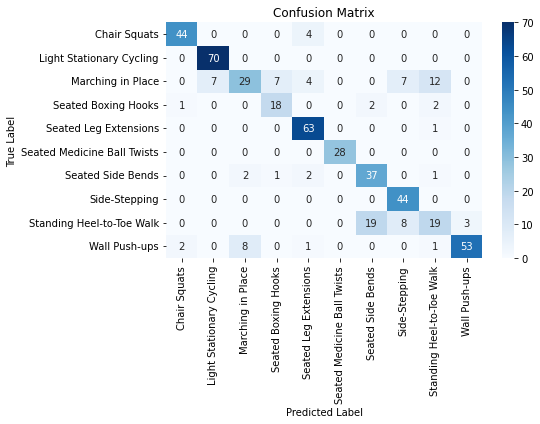

In [17]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=activity_names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=activity_names, yticklabels=activity_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('HART_confusion_matrix.png')
plt.show()

# Subject-wise Performance Reports

In [18]:
subject_reports = {}
subject_accuracies = {}

for subject_id in df['Subject_ID'].unique():
    subject_df = df[df['Subject_ID'] == subject_id]
    
    sub_X_list, sub_y_list = [], []
    
    for activity in subject_df['Activity_Encoded'].unique():
        if subject_id == 5 and activity not in subject_5_valid_activities_encoded:
            continue
        
        activity_df = subject_df[subject_df['Activity_Encoded'] == activity]
        
        features = activity_df[sensor_cols].values
        labels = activity_df['Activity_Encoded'].values
        
        windows = create_overlapping_windows(features, window_size, step_size, num_features)
        window_labels = assign_labels_to_windows(labels, window_size, step_size)
        
        val_idx = int(len(windows) * 0.85)
        sub_X = windows[val_idx:]
        sub_y = window_labels[val_idx:]
        
        if len(sub_X) > 0:
            sub_X_list.append(sub_X)
            sub_y_list.append(sub_y)
    
    if len(sub_X_list) > 0:
        subject_X_test = np.concatenate(sub_X_list)
        subject_y_test = np.concatenate(sub_y_list)
        
        subject_y_pred_prob = model.predict(subject_X_test)
        subject_y_pred = np.argmax(subject_y_pred_prob, axis=1)
        
        subject_accuracy = np.mean(subject_y_pred == subject_y_test)
        subject_accuracies[subject_id] = subject_accuracy
        
        subject_reports[f"Subject_{subject_id}"] = classification_report(
            subject_y_test, subject_y_pred, 
            target_names=activity_names, 
            labels=np.arange(len(activity_names)),
            output_dict=True
        )

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 730ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 887ms/step


# Display Subject-wise Classification Reports

In [19]:
for subject_id, report in subject_reports.items():
    print(f"\nClassification Report for {subject_id}:")
    print(f"Overall Accuracy: {subject_accuracies[int(subject_id.split('_')[1])]*100:.2f}%\n")
    
    print(f"{'Activity':30} {'precision':10} {'recall':10} {'f1-score':10} {'support':10}")
    print("-" * 70)
    
    for activity_idx, activity_name in enumerate(activity_names):
        if activity_name in report:
            metrics = report[activity_name]
            support = metrics['support']
            if support > 0:
                print(f"{activity_name:30} {metrics['precision']:10.2f} {metrics['recall']:10.2f} "
                      f"{metrics['f1-score']:10.2f} {support:10.0f}")
    
    print("\n" + "-" * 70)
    print(f"{'accuracy':30} {report['accuracy']:10.2f} {' ':21} {report['macro avg']['support']:10.0f}")
    
    print(f"{'macro avg':30} {report['macro avg']['precision']:10.2f} "
          f"{report['macro avg']['recall']:10.2f} {report['macro avg']['f1-score']:10.2f} "
          f"{report['macro avg']['support']:10.0f}")
    
    print(f"{'weighted avg':30} {report['weighted avg']['precision']:10.2f} "
          f"{report['weighted avg']['recall']:10.2f} {report['weighted avg']['f1-score']:10.2f} "
          f"{report['weighted avg']['support']:10.0f}")


Classification Report for Subject_1:
Overall Accuracy: 71.43%

Activity                       precision  recall     f1-score   support   
----------------------------------------------------------------------
Chair Squats                         0.67       1.00       0.80          6
Light Stationary Cycling             1.00       1.00       1.00          6
Marching in Place                    0.00       0.00       0.00          9
Seated Leg Extensions                0.76       1.00       0.87         13
Seated Medicine Ball Twists          1.00       1.00       1.00          4
Seated Side Bends                    1.00       1.00       1.00          9
Standing Heel-to-Toe Walk            1.00       1.00       1.00          2
Wall Push-ups                        0.00       0.00       0.00          7

----------------------------------------------------------------------
accuracy                             0.71                               56
macro avg                            0.54  

# Activity-wise Performance

In [20]:
activity_performance = {}

for i, activity_name in enumerate(activity_names):
    activity_indices = (y_test == i)
    if np.sum(activity_indices) > 0:
        activity_X = X_test[activity_indices]
        activity_y = y_test[activity_indices]
        
        activity_pred_prob = model.predict(activity_X)
        activity_pred = np.argmax(activity_pred_prob, axis=1)
        
        activity_accuracy = np.mean(activity_pred == activity_y)
        activity_performance[activity_name] = {
            'accuracy': activity_accuracy,
            'support': np.sum(activity_indices)
        }

print("\nActivity-wise Performance:")
for activity, metrics in activity_performance.items():
    print(f"{activity:30} Accuracy: {metrics['accuracy']*100:6.2f}%  Support: {metrics['support']}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 469ms/step

Activity-wise Performance:
Chair Squats                   Accuracy:  97.92%  Support: 48
Light Stationary Cycling       Accuracy: 100.00%  Support: 70
Marching in Place              Accuracy:  43.94%  Support: 66
Seated Boxing Hooks            Accuracy:  91.30%  Support: 23
Seated Leg Extensions          Accuracy:  93.75%  Support: 64
Seated Medicine Ball Twists    Accuracy:  96.43%  Support: 28
Seated Side Bends              Accuracy:  88.37%  Support: 43
Side-Stepping                  Accuracy: 100.00%  Support: 44
Standing Heel-to-Toe Walk      Accuracy:  42.86%  Support: 49
Wall Push-ups                  Accurac

# Learning Curves for Model Training

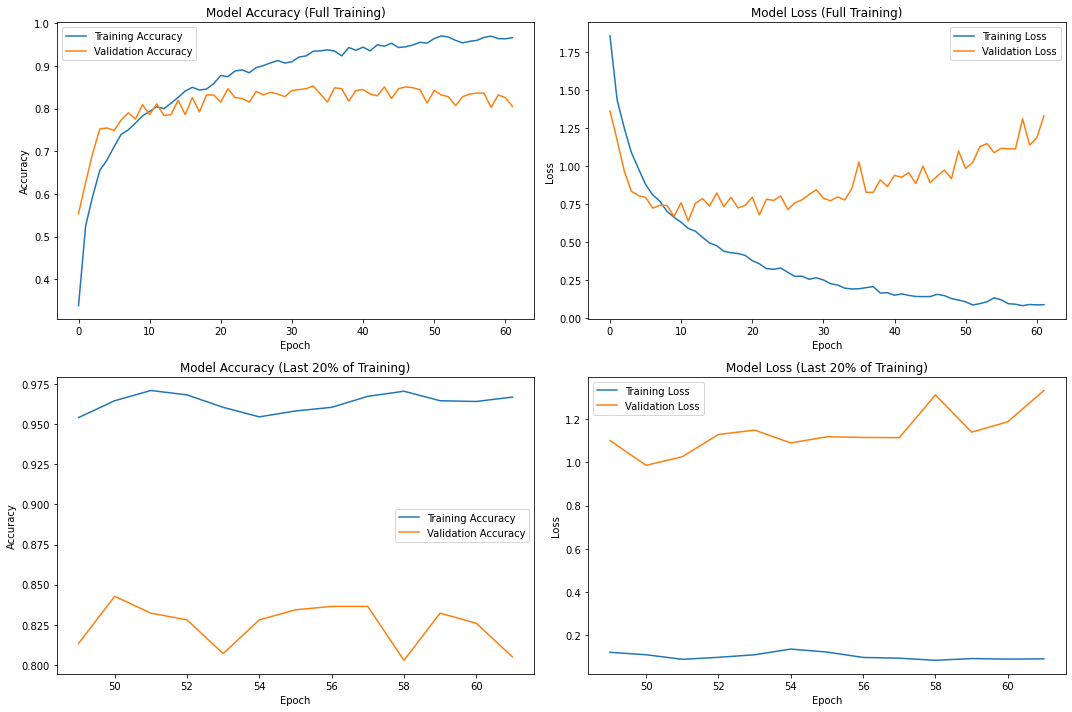

In [21]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Full Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Full Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

train_length = len(history.history['accuracy'])
start_idx = int(train_length * 0.8)

plt.subplot(2, 2, 3)
plt.plot(range(start_idx, train_length), history.history['accuracy'][start_idx:], label='Training Accuracy')
plt.plot(range(start_idx, train_length), history.history['val_accuracy'][start_idx:], label='Validation Accuracy')
plt.title('Model Accuracy (Last 20% of Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(range(start_idx, train_length), history.history['loss'][start_idx:], label='Training Loss')
plt.plot(range(start_idx, train_length), history.history['val_loss'][start_idx:], label='Validation Loss')
plt.title('Model Loss (Last 20% of Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('HART_training_history_500_epochs.png')
plt.show()

# Save Training History

In [22]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('HART_training_history_500_epochs.csv')

print("Training history successfully saved to 'HART_training_history_500_epochs.csv'")

Training history successfully saved to 'HART_training_history_500_epochs.csv'
